A notebook for investigating the temperamental exposure behaviour.

Hypothesis is that this is a function of the frames-per-second (fps) setting, so here we will repeat a series of exposures across a range of ~0 - 5 seconds, with different FPS settings, and we will look for patterns in where the poor performance occurs.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Overview

- set exposures to trial
- set FPS to trial
- connect to cameras
- for each FPS
    - set FPS (for each camera)
    - for each camera
        - expose at each exposure
        - plot mean and std dev. vs. exposure time, logarithmic
        - record mean, std dev, exposure
- for each camera, 
    - overplot mean and std dev vs exposure, for all FPS superimposed.

Criteria:
- look for a straight line relationship between mean and exposure (after read noise has been exceeded)
- look for sections of poor performance, and look for responsible FPS setting.
- find the lowest allowed FPS setting for each exposure range.

# Setting the exposures

Minimum exposure: 60 µs, or 6E-5 seconds
Maximum exposure: for these purposes, set this to 5 seconds.
Let's ensure we test each power in depth. Let's use a scaling factor of 1.15 to increase exposures each time.

To get from 60 µs to 6 seconds, this requires: log(6/6E-5) / log(1.15) ~ 83 steps. This is a reasonable number of exposures to acquire.


In [11]:
import numpy as np
min_exp = 6.01E-5
max_exp = 2.0
steps = 50
base = np.power((max_exp/min_exp), 1.0/steps)
exposures = min_exp * base**np.arange(0, steps+1)
exposures

array([6.01000000e-05, 7.40146317e-05, 9.11508437e-05, 1.12254511e-04,
       1.38244198e-04, 1.70251138e-04, 2.09668474e-04, 2.58211895e-04,
       3.17994315e-04, 3.91617839e-04, 4.82287023e-04, 5.93948360e-04,
       7.31462048e-04, 9.00813546e-04, 1.10937409e-03, 1.36622154e-03,
       1.68253551e-03, 2.07208397e-03, 2.55182249e-03, 3.14263231e-03,
       3.87022917e-03, 4.76628264e-03, 5.86979457e-03, 7.22879673e-03,
       8.90244139e-03, 1.09635761e-02, 1.35019142e-02, 1.66279402e-02,
       2.04777183e-02, 2.52188150e-02, 3.10575924e-02, 3.82481908e-02,
       4.71035899e-02, 5.80092322e-02, 7.14397997e-02, 8.79798746e-02,
       1.08349385e-01, 1.33434938e-01, 1.64328416e-01, 2.02374496e-01,
       2.49229181e-01, 3.06931881e-01, 3.77994179e-01, 4.65509151e-01,
       5.73285996e-01, 7.06015837e-01, 8.69475910e-01, 1.07078102e+00,
       1.31869322e+00, 1.62400322e+00, 2.00000000e+00])

# Connecting to cameras

In [4]:
import orochi_sim_ctrl as osc

ic = osc.start_ic()
camera_config = osc.load_camera_config()
cameras = osc.connect_cameras(ic, camera_config)
osc.configure_cameras(cameras)

Device 0 (DMK 33GX249 10910288) succesfully connected.
Device 1 (DMK 33GX249 10910273) succesfully connected.
Device 2 (DMK 33GX249 10910289) succesfully connected.
Device 3 (DMK 33GX249 10910294) succesfully connected.
Device 4 (DMK 33GX249 10910291) succesfully connected.
Device 5 (DMK 33GX249 10910295) succesfully connected.
Device 7 (DMK 33GX249 23120778) succesfully connected.
Device 6 (DMK 33GX249 10910265) succesfully connected.
-----------------------------------
Device 0 (DMK 33GX249 10910288)
-----------------------------------
1
Video Format set to : Y16 (1920x1200)
1
Sink Format set to : "SinkFormats.Y16"
Setting Frame Rate to : 30.0 FPS
set frame rate err: 1
Frame Rate set to : 33 FPS
Brightness Value set to 0
Contrast Value set to 0
Sharpness Value set to 0
Gamma Value set to 100
Gain Value set to 4.269999980926514
Gain Auto set to 0
Exposure Value set to 0.009999999776482582
Exposure Auto set to 1
Exposure Auto Reference set to 80
Exposure Auto Max Value set to 10.0
Expo

# Setting FPS values to trial

FPS values should be trialled of 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20, 25, 30.

However, not all of the short FPS need to be tried. Let's trials:
1, 2, 5, 10, 16, 20 , 25, 30.

In [13]:
fpss = [1, 5, 10, 20, 30]
# fpss = [10, 20, 30]

# Running the trials

In [14]:
import pandas as pd

def exposure_trials(camera, fpss, exposures) -> pd.DataFrame:    
    # just caputre frame at each exposure, log the exposure actually used and the exposure commanded, and the mean and std dev of the resultant image.
    fps_dat = []
    exp_dat = []
    exp_act = []
    ave_dat = []
    std_dat = []

    for fps in fpss:
        camera.set_frame_rate(fps)
        for exposure in exposures:
            camera.set_exposure(exposure)
            img = camera.image_capture()
            img_mean = np.mean(img)
            img_std = np.std(img)
            exposure_actual = camera.get_exposure_value()
            fps_dat.append(fps)
            exp_dat.append(exposure)
            exp_act.append(exposure_actual)
            ave_dat.append(img_mean)
            std_dat.append(img_std)
    
    results = pd.DataFrame({'fps': fps_dat, 'exposure': exp_dat, 'exposure_actual': exp_act, 'mean': ave_dat, 'std': std_dat})
    return results

Setting Frame Rate to : 1 FPS
set frame rate err: 1
Frame Rate set to : 977 FPS
Exposure Auto set to 0
Exposure Value set to 6.009999924572185e-05
Imaging with Exposure: 5.999999848427251e-05 s
+Good exposure 5.999999848427251e-05 Image recieved
Exposure Auto set to 0
Exposure Value set to 7.401463517453521e-05
Imaging with Exposure: 7.400000322377309e-05 s
+Good exposure 7.400000322377309e-05 Image recieved
Exposure Auto set to 0
Exposure Value set to 9.115084685618058e-05
Imaging with Exposure: 9.100000170292333e-05 s
+Good exposure 9.100000170292333e-05 Image recieved
Exposure Auto set to 0
Exposure Value set to 0.00011225451453356072
Imaging with Exposure: 0.00011200000153621659 s
+Good exposure 0.00011200000153621659 Image recieved
Exposure Auto set to 0
Exposure Value set to 0.00013824419875163585
Imaging with Exposure: 0.00013800000306218863 s
+Good exposure 0.00013800000306218863 Image recieved
Exposure Auto set to 0
Exposure Value set to 0.00017025113629642874
Imaging with Exp

C:\Users\kameken\rstabbins\orochi_simulator_control\src\orochi_sim_proc.py:836: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  fig.tight_layout()
C:\Users\kameken\rstabbins\orochi_simulator_control\src\orochi_sim_proc.py:842: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  fig.tight_layout()


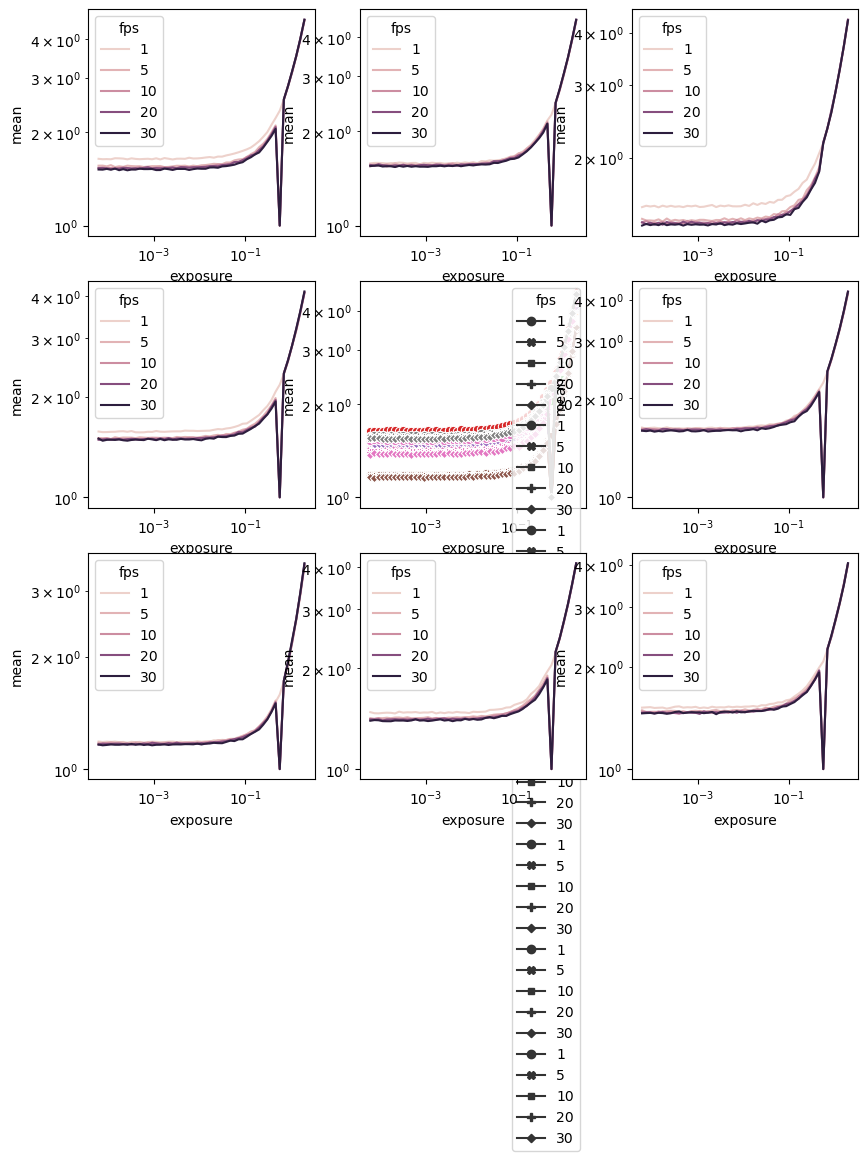

In [15]:
import seaborn as sns
import orochi_sim_proc as osp

fig_exp, ax_exp = osp.grid_plot() # init the exposure grid plot
cntr_exp = ax_exp[8] # centre plot for overlaying the exposures

results_dict = {}
for camera in cameras:
    results = exposure_trials(camera, fpss, exposures)
    num = camera.number
    sns.lineplot(data=results, x='exposure', y='mean', hue='fps', markers=True, dashes=False, ax=ax_exp[num])
    ax_exp[num].set_xscale('log')
    ax_exp[num].set_yscale('log')
    sns.lineplot(data=results, x='exposure', y='mean', style='fps', markers=True, dashes=False, ax=cntr_exp)
    cntr_exp.set_xscale('log')
    cntr_exp.set_yscale('log')
    results_dict[camera] = results
osp.show_grid(fig_exp, ax_exp)

In [18]:
results

,fps,exposure,exposure_actual,mean,std
0,1,0.000060,0.000060,1.580728,1.681276
1,1,0.000074,0.000074,1.585708,1.680440
2,1,0.000091,0.000091,1.585811,1.681370
3,1,0.000112,0.000112,1.584055,1.683419
4,1,0.000138,0.000138,1.578430,1.672896
...,...,...,...,...,...
250,30,0.869476,0.869475,2.736320,3.155137
251,30,1.070781,1.070780,3.062684,3.591451
252,30,1.318693,1.318693,3.447990,4.114569
253,30,1.624003,1.624003,3.944825,4.664395


c:\Users\kameken\Anaconda3\envs\orochi_sim_ctrl\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\kameken\Anaconda3\envs\orochi_sim_ctrl\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\kameken\Anaconda3\envs\orochi_sim_ctrl\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\kameken\Anaconda3\envs\orochi_sim_ctrl\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\kameken\Anaconda3\envs\orochi_sim_ctrl\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwa

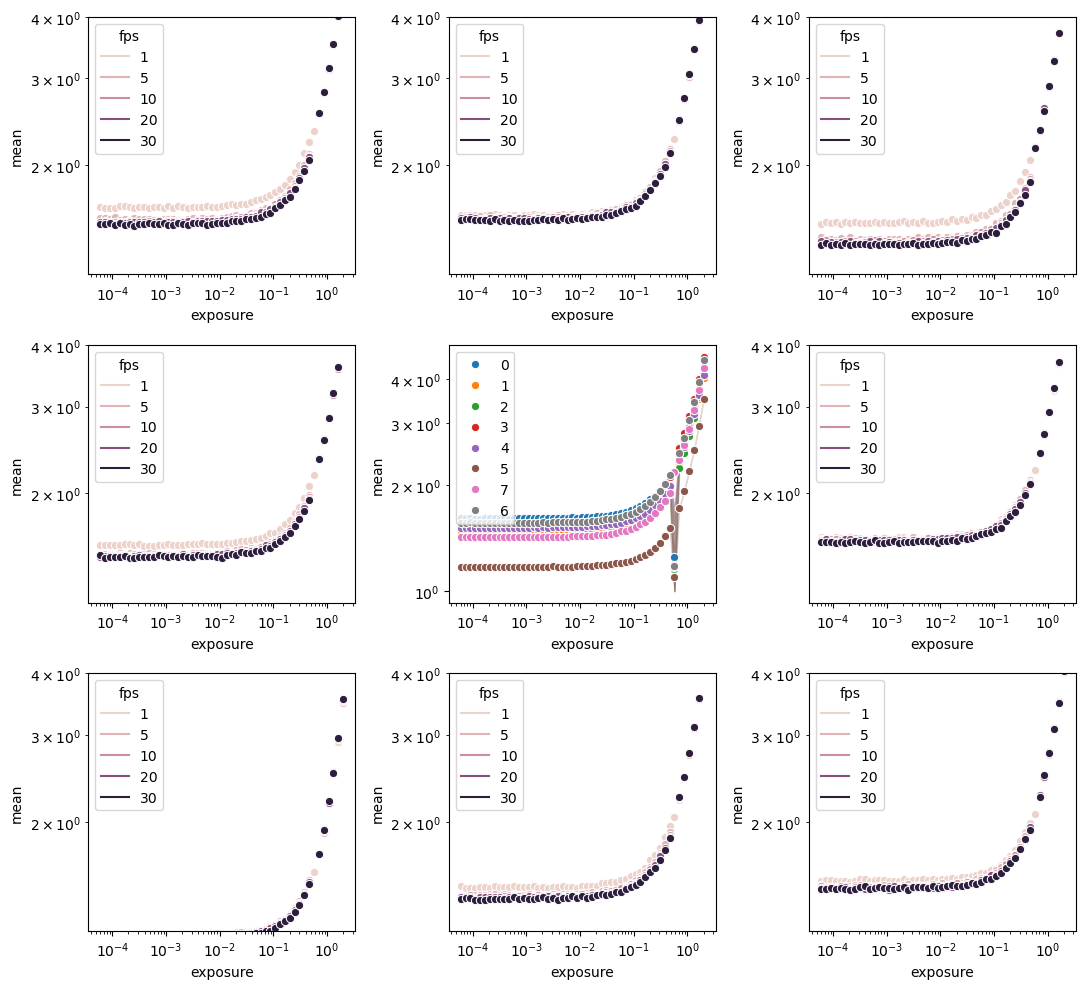

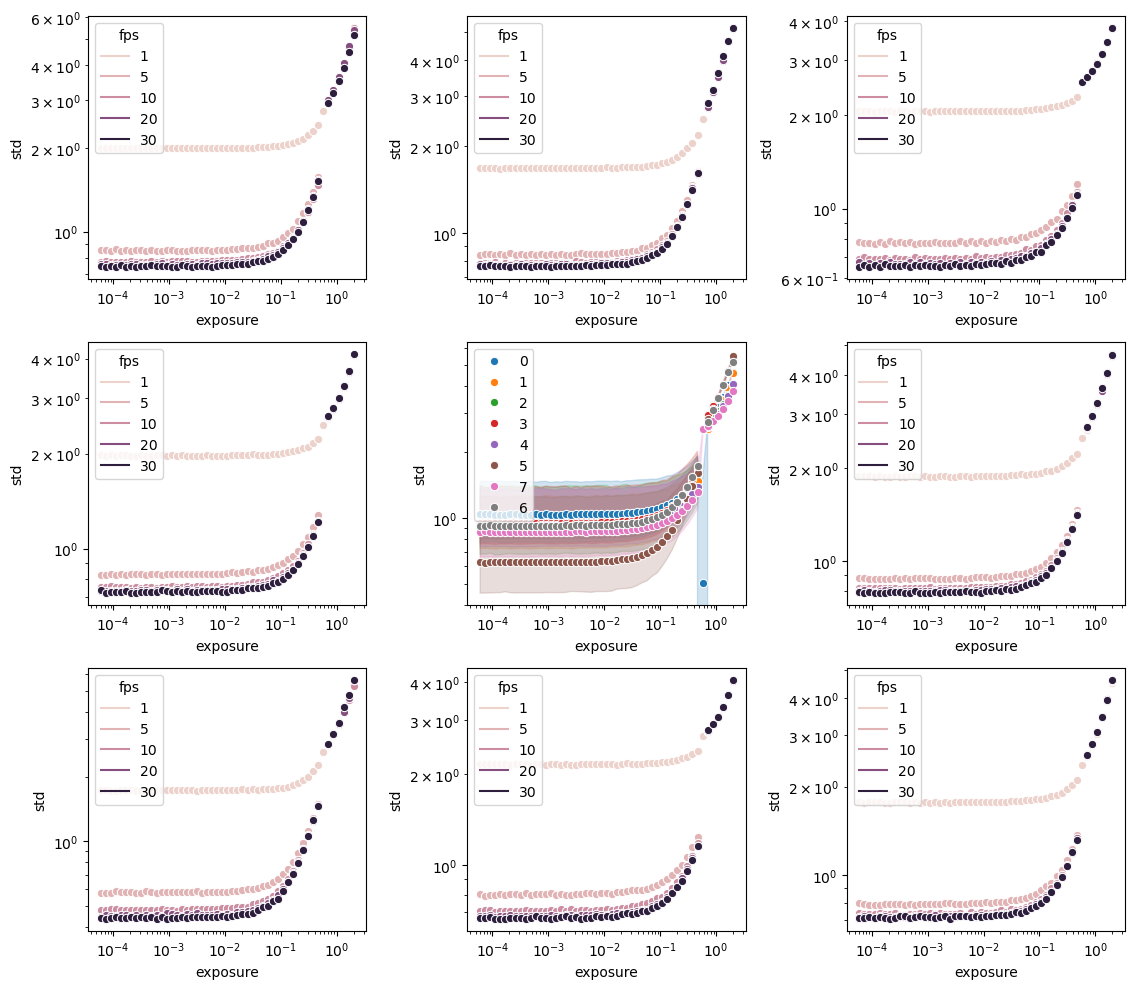

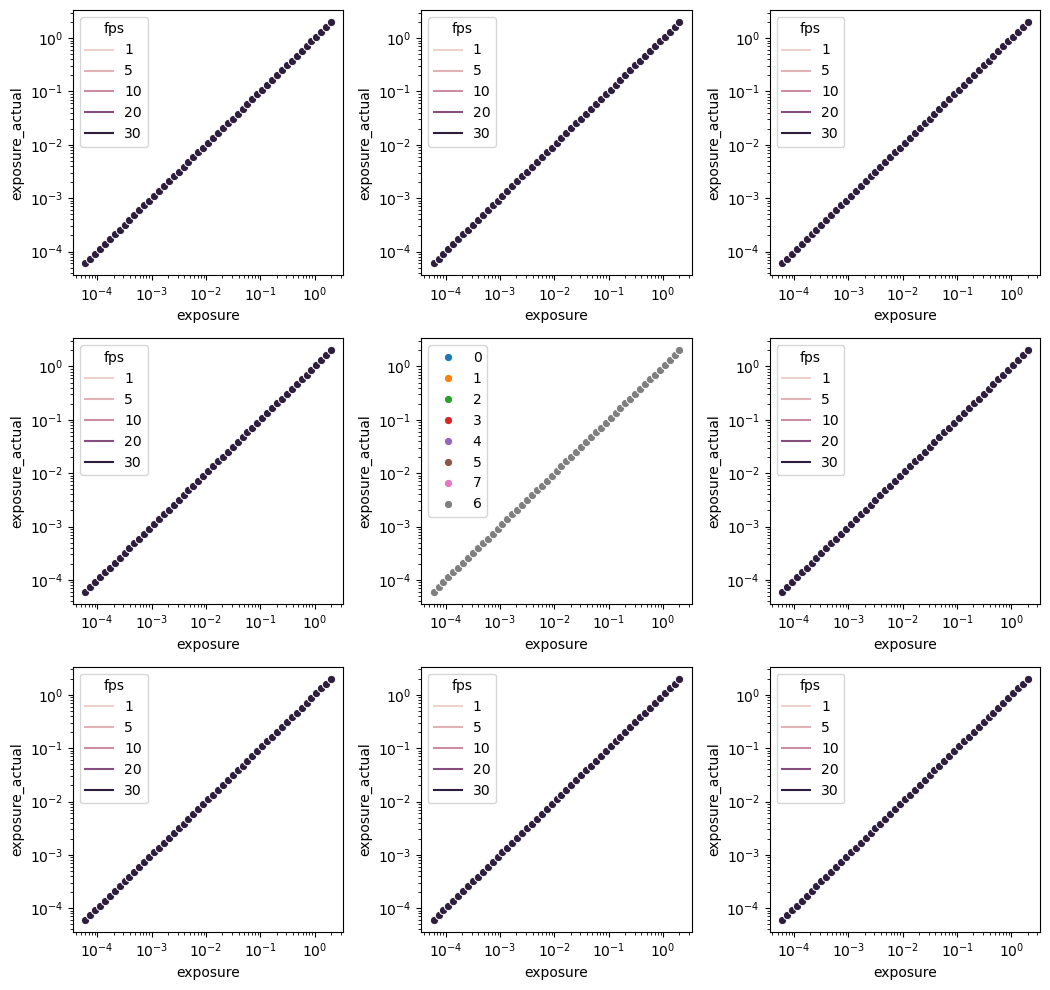

In [30]:
import seaborn as sns
import orochi_sim_proc as osp

fig_exp, ax_exp = osp.grid_plot() # init the exposure grid plot
cntr_exp = ax_exp[8] # centre plot for overlaying the exposures

fig_std, ax_std = osp.grid_plot() # init the exposure grid plot
cntr_std = ax_std[8] # centre plot for overlaying the exposures

fig_eexp, ax_eexp = osp.grid_plot() # init the exposure grid plot
cntr_eexp = ax_eexp[8] # centre plot for overlaying the exposures

for camera in cameras:
    num = camera.number
    results = results_dict[camera]

    sns.lineplot(data=results, x='exposure', y='mean', hue='fps', marker='o', linestyle='', dashes=False, ax=ax_exp[num])
    ax_exp[num].set_xscale('log')
    ax_exp[num].set_yscale('log')
    ax_exp[num].set_ylim(1.2,4.0)
    sns.lineplot(data=results, x='exposure', y='mean', marker='o', linestyle='', dashes=False, ax=cntr_exp, label=num)
    cntr_exp.set_xscale('log')
    cntr_exp.set_yscale('log')
    ax_exp[num].set_ylim(1.2,4.0)

    sns.lineplot(data=results, x='exposure', y='std', hue='fps', marker='o', linestyle='',dashes=False, ax=ax_std[num])
    ax_std[num].set_xscale('log')
    ax_std[num].set_yscale('log')
    # ax_exp[num].set_ylim(1.0,4.0)
    sns.lineplot(data=results, x='exposure', y='std', marker='o', linestyle='', dashes=False, ax=cntr_std, label=num)
    cntr_std.set_xscale('log')
    cntr_std.set_yscale('log')
    # ax_exp[num].set_ylim(1.0,4.0)

    sns.lineplot(data=results, x='exposure', y='exposure_actual', hue='fps', marker='o', linestyle='', dashes=False, ax=ax_eexp[num])
    ax_eexp[num].set_xscale('log')
    ax_eexp[num].set_yscale('log')
    sns.lineplot(data=results, x='exposure', y='exposure_actual', marker='o', linestyle='', dashes=False, ax=cntr_eexp, label=num)
    cntr_eexp.set_xscale('log')
    cntr_eexp.set_yscale('log')

osp.show_grid(fig_exp, ax_exp)
osp.show_grid(fig_std, ax_std)
osp.show_grid(fig_eexp, ax_eexp)

Observations:

- actual exposure used is mostly identical to requested exposure
- only the 1 FPS setting covers the complete range of exposures
- the FPS settings seems to have an effect on read noise - fewer Frames per second result in greater read noise
- fewer frames per second seem to align with the standard deviation of longer duration exposures.



Next steps:

The next things to try are:
- greater granularity of the FPS mode
- fewer exposures at low exposure, more exposures at higher - i.e. perhaps a more balanced distribution of the exposure values?
- reverse the order of trialing the different FPS values, in case it is increasing temperature that is effecting the readout. Also revese the exposure orders.